In [14]:
import uproot
import awkward as ak
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import hist
import vector
import os
import subprocess
import gc
print("uproot version", uproot.__version__)
print("awkward version", ak.__version__)
print("numpy version", np.__version__)
print("matplotlib version", matplotlib.__version__)
print("hist version", hist.__version__)
print("vector version", vector.__version__)
#print("os version", os.__version__)
#print("subprocess version", subprocess.__version__)
#print("gc version", gc.__version__)

uproot version 5.0.12
awkward version 2.4.3
numpy version 1.25.2
matplotlib version 3.8.0
hist version 2.7.2
vector version 1.1.1


In [15]:
vector.register_awkward() 

In [16]:
DATATYPE = "mc"
assert((DATATYPE == "mc") or (DATATYPE == "data"))
BASEDIR = "/pbs/throng/training/nantes-m2-rps-exp/data" # basedir where to look for runXXX.DATATYPE.root files
IS_MC = True if DATATYPE == "mc" else False

In [17]:
def data_file_path(run,is_mc=IS_MC,dest=BASEDIR):
    datatype="mc" if is_mc else "data"
    print({dest},"/run",{run},".",{datatype},".root")
    return f"{dest}/run{run}.{datatype}.root"

In [18]:
SAMPLE_RUNS = [290860, 291694, 291399]

In [19]:
file = uproot.open(data_file_path(SAMPLE_RUNS[0],IS_MC))
events = file["eventsTree"]
events.show()
events.num_entries

{'/pbs/throng/training/nantes-m2-rps-exp/data'} /run {290860} . {'mc'} .root
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
runNumber            | int32_t                  | AsDtype('>i4')
xVtx                 | double                   | AsDtype('>f8')
yVtx                 | double                   | AsDtype('>f8')
zVtx                 | double                   | AsDtype('>f8')
isCINT               | bool                     | AsDtype('bool')
isCMSL               | bool                     | AsDtype('bool')
isCMSH               | bool                     | AsDtype('bool')
isCMLL               | bool                     | AsDtype('bool')
isCMUL               | bool                     | AsDtype('bool')
nMuons               | int32_t                  | AsDtype('>i4')
Muon_E               | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
Muon_Px              | st

150000

In [20]:
def mag(Px, Py, Pz):
    return np.sqrt(Px*Px + Py*Py + Pz*Pz)

def rest_mass(E, Px, Py, Pz):
    P = mag(Px, Py, Pz)
    return np.sqrt(np.abs(E*E - P*P))


def getTracks(events):
    return ak.zip({"px":events["Muon_Px"],
                       "py":events["Muon_Py"],
                       "pz":events["Muon_Pz"],
                       "E":events["Muon_E"],
                       "charge":events["Muon_Charge"],
                       "thetaAbs":events["Muon_thetaAbs"],
                       "matched":events["Muon_matchedTrgThreshold"]},
                    with_name='Momentum4D')


def scan(dataDescription, 
              hMag:hist.Hist, hPhi:hist.Hist, hEta:hist.Hist, hPt:hist.Hist, hMass:hist.Hist, hMass_OS:hist.Hist, hMass_LS:hist.Hist,
              eventSelector = lambda x:[True]*len(x),
              trackSelector = lambda x:[True]*len(x), 
              verbose:bool = False):
    """ Loop over data to fill the invariant mass histogram.
        
        :param: dataDescription: is anything uproot.iterate can take.
                typical something like run*.data.root:eventsTree in our case
        :param: eventSelector: returns an array of bool from an array of events
        :param: trackSelector: returns an array of bool from an array of tracks
        print(dir(vector.backends.awkward.MomentumArray4D))
    """
    
    for batch in uproot.iterate(dataDescription,
                                ["isCINT", "isCMUL", "isCMSL", "nMuons", "Muon_Px", "Muon_Py", "Muon_Pz", "Muon_E", "Muon_Charge", "Muon_thetaAbs", "Muon_matchedTrgThreshold"],                                
                                report = True):
        events = batch[0] # batch[1] is the report info
        if len(events) < 1000:
            print("something is wrong",batch[1]) # this is a protection for some corrupted input data files 
            break
            
        goodEvents = events[eventSelector(events)] 
        
        tracks = getTracks(events)
        goodTracks = tracks[trackSelector(tracks)]
        #goodTracks.show()
    
        hMag.fill(ak.flatten(goodTracks.p))
        hPhi.fill(ak.flatten(goodTracks.phi))
        hEta.fill(ak.flatten(goodTracks.eta))
        hPt.fill(ak.flatten(goodTracks.pt))
        hMass.fill(ak.flatten(goodTracks.mass))

        
        pairs = ak.combinations(goodTracks, 2)
        
        Px = pairs["0"].px + pairs["1"].px
        Py = pairs["0"].py + pairs["1"].py
        Pz = pairs["0"].pz + pairs["1"].pz
        E = pairs["0"].E + pairs["1"].E
        charge = pairs["0"].charge + pairs["1"].charge
        
        Pair2 = ak.zip({"px":Px,
                       "py":Py,
                       "pz":Pz,
                       "E":E,
                       "charge":charge},
                    with_name='Momentum4D')
        
        hMass_OS.fill(ak.flatten(Pair2[Pair2.charge==0].mass))
        
        """
        # Calcul de la masse invariante pour OS
        condition = (charge == 0)
        Pxsel = Px[condition] 
        Pysel = Py[condition]
        Pzsel = Pz[condition]
        Esel = E[condition]
        
        #mass_OS = rest_mass(Esel, Pxsel, Pysel, Pzsel)
        #hMass_OS.fill(ak.flatten(mass_OS))
        
        
        # Calcul de la masse invariante pour LS
        condition = (charge != 0)
        Pxsel = Px[condition] 
        Pysel = Py[condition]
        Pzsel = Pz[condition]
        Esel = E[condition]
        
        #mass_LS = rest_mass(Esel, Pxsel, Pysel, Pzsel)
        #hMass_LS.fill(ak.flatten(mass_LS))"""
        
        if verbose:
            print(batch[1])
        gc.collect()

In [21]:
%%time

hMag = hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 100, name = '$|p|$'))
hPhi = hist.Hist(hist.axis.Regular(bins = 200, start = -22/7, stop = 22/7, name = '$\phi$'))

hEta = hist.Hist(hist.axis.Regular(bins = 100, start = -6, stop = 0, name = '$\eta$'))
hPt = hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 100, name = '$p_T$'))
hMass = hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 0.2, name = '$m_{\mu}$'))

hMass_OS = hist.Hist(hist.axis.Regular(bins = 100, start = 1.5, stop = 5, name = '$m_{\mu \mu}$'))
hMass_LS = hist.Hist(hist.axis.Regular(bins = 100, start = 1.5, stop = 5, name = '$m_{\mu \mu}$'))

hMass_OS_cut = hist.Hist(hist.axis.Regular(bins = 100, start = 1.5, stop = 5, name = '$m_{\mu \mu}$'))
hMass_LS_cut = hist.Hist(hist.axis.Regular(bins = 100, start = 1.5, stop = 5, name = '$m_{\mu \mu}$'))

hMass_OS_test = hist.Hist(hist.axis.Regular(bins = 100, start = 1.5, stop = 5, name = '$m_{\mu \mu}$'))
hMass_LS_test = hist.Hist(hist.axis.Regular(bins = 100, start = 1.5, stop = 5, name = '$m_{\mu \mu}$'))


scan(dataDescription = f"{BASEDIR}/run{SAMPLE_RUNS[0]}.{DATATYPE}.root:eventsTree",
          hMag = hMag, hPhi = hPhi, hEta = hEta, hPt = hPt, hMass = hMass, hMass_OS = hMass_OS, hMass_LS = hMass_LS)

"""scan(dataDescription = f"{BASEDIR}/run{SAMPLE_RUNS[0]}.{DATATYPE}.root:eventsTree",
          hMag = hMag, hPhi = hPhi, hEta = hEta, hPt = hPt, hMass = hMass, hMass_OS = hMass_OS_test, hMass_LS = hMass_LS_test,
          eventSelector = lambda x: x["isCMUL"] == True,
          trackSelector = lambda x: (((x.pt > 2) & (x.pt < 3)) & ((x.eta > -4) & (x.eta < -2.5))) )"""

CPU times: user 961 ms, sys: 19.4 ms, total: 980 ms
Wall time: 979 ms


'scan(dataDescription = f"{BASEDIR}/run{SAMPLE_RUNS[0]}.{DATATYPE}.root:eventsTree",\n          hMag = hMag, hPhi = hPhi, hEta = hEta, hPt = hPt, hMass = hMass, hMass_OS = hMass_OS_test, hMass_LS = hMass_LS_test,\n          eventSelector = lambda x: x["isCMUL"] == True,\n          trackSelector = lambda x: (((x.pt > 2) & (x.pt < 3)) & ((x.eta > -4) & (x.eta < -2.5))) )'

/pbs/throng/training/nantes-m2-rps-exp/miniconda3/envs/qqbar2mumu/lib/python3.9/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


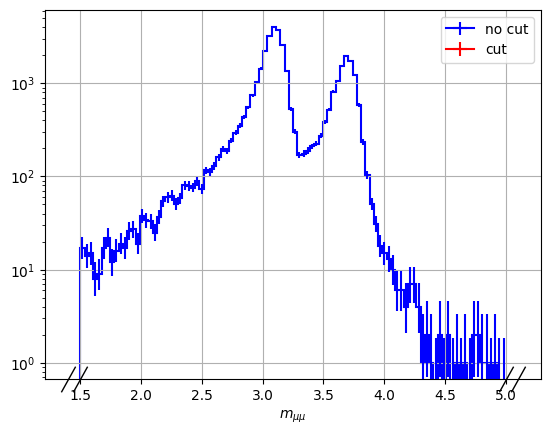

In [22]:
hMass_OS.plot(color = "blue", label = "no cut")
hMass_OS_cut.plot(color = "red", label = "cut")
plt.yscale('log')
plt.grid(True)
plt.legend()

/pbs/throng/training/nantes-m2-rps-exp/miniconda3/envs/qqbar2mumu/lib/python3.9/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/pbs/throng/training/nantes-m2-rps-exp/miniconda3/envs/qqbar2mumu/lib/python3.9/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/tmp/ipykernel_199/2028320395.py:3: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


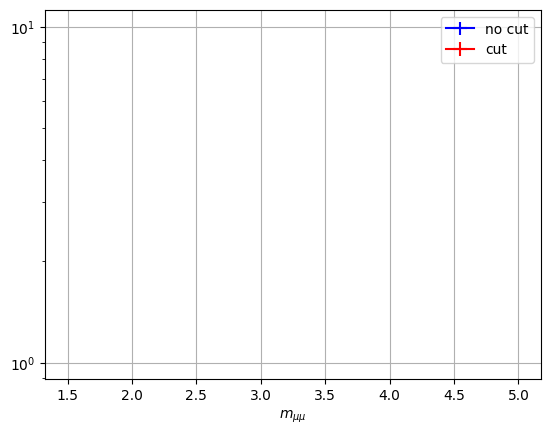

In [23]:
hMass_LS.plot(color = "blue", label = "no cut")
hMass_LS_cut.plot(color = "red", label = "cut")
plt.yscale('log')
plt.grid(True)
plt.legend()

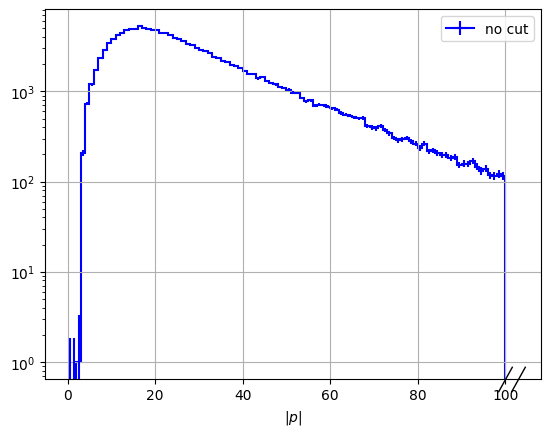

In [24]:
hMag.plot(color = "blue", label = "no cut")
plt.yscale('log')
plt.grid(True)
plt.legend()

In [29]:
m = events.arrays(["nMuons","Muon_Px","Muon_Py","Muon_Pz","Muon_Charge"],how="zip",entry_stop=150000)
dimuons = [m['nMuons']==2]
X=np.arange(150000)[m['nMuons']==2]

print(X)
print(len(X))

dimuons_charge = [m['Muon_Charge']]

    

[     4      6      9 ... 149989 149993 149996]
36813
